# 3- EDA (Statistical Analysis)

This section will furthre analyze our wrangle datasets by using descriptive statistics and some frequentist tests.

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy.stats import pearsonr
from scipy.stats import norm
from scipy.stats import ttest_ind
from seaborn import color_palette as cmap
sns.set()

In [2]:
demand=pd.read_csv("../data/processed/load_data.csv",parse_dates=['time'],index_col=['time'])

In [3]:
weather=pd.read_csv("../data/processed/weather_new_data.csv",parse_dates=['dt_iso'],index_col=['dt_iso'])

In [4]:
weather.index.name='time'

In [5]:
demand_actual=demand['total load actual']

In [6]:
winter_dem=demand_actual[demand_actual.index.month.isin([1,2,3])]
spring_dem=demand_actual[demand_actual.index.month.isin([4,5,6])]
summer_dem=demand_actual[demand_actual.index.month.isin([7,8,9])]
fall_dem=demand_actual[demand_actual.index.month.isin([10,11,12])]

# 1. Examining effect of temperature and hour of day on demand

In [8]:
demand_by_week=demand_actual.resample("W").mean()
temperature_by_week=weather.temp_c.resample("W").mean()

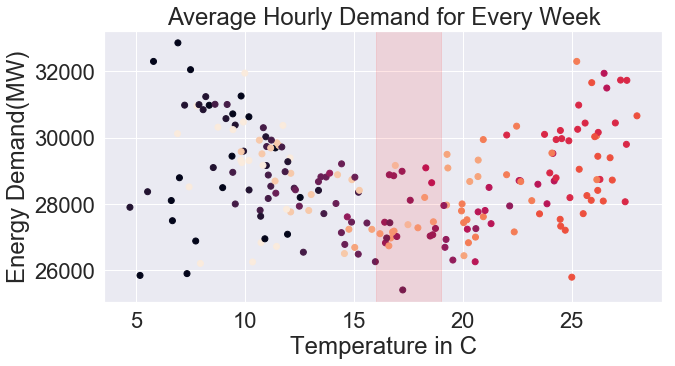

In [81]:
plt.figure(figsize=[10,5])
plt.scatter(temperature_by_week,demand_by_week, c=demand_by_week.index.month)
plt.ylabel("Energy Demand(MW)")
plt.xlabel("Temperature in C")
plt.title("Average Hourly Demand for Every Week")
plt.axvspan(16,19,alpha=0.1,color='red');

We see a parabolic relationship. The black points represent early months of the year and the points get lighter as the year progresses.

- Demand decreases linearly as the average daily temperature drops from the lows to 16-19C.  
- Demand increases linearly as the average daily temperature drops from 16-19C to the highs.

This can be found by plotting correlations of 3 degree Celsisus intervals and examine where it changes from negative to positive.


In [48]:
correlations={}
for temp in range(5,32):
    if (temp+3)<32:
        temps=weather.temp_c[weather.temp_c.between(temp,temp+3)]
        demands=demand_actual[temps.index]
        correlations[str(temp)+"->"+ str(temp+3)]= pearsonr(temps,demands)[0]

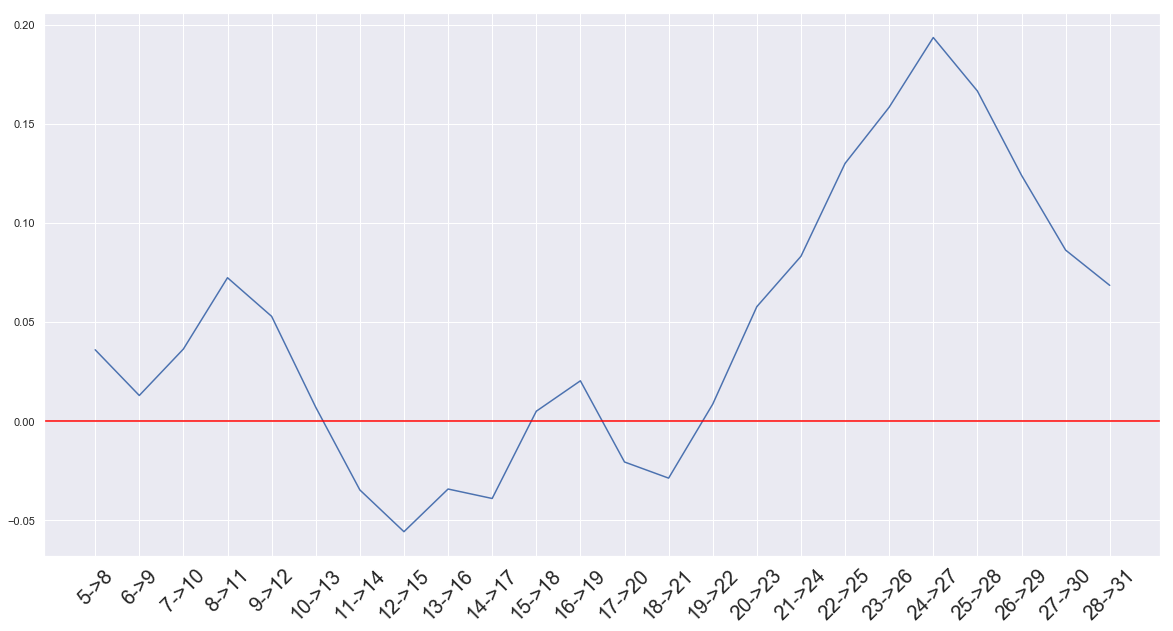

In [49]:
plt.figure(figsize=[20,10])
plt.plot(pd.Series(correlations))
plt.axhline(0,color='red')
plt.xticks(rotation=45, size=20);

Intraday variability is causing innacurate measurement with correlation. It is best to achieve the hourly mean across an entire week and sample then. 

In [51]:
correlations={}
for temp in range(5,32):
    if (temp+3)<32:
        temps=weather.temp_c[weather.temp_c.between(temp,temp+3)].resample("W").mean().dropna()
        demands=demand_actual.resample("W").mean()[temps.index]
        correlations[str(temp)+"->"+str(temp+3)]= pearsonr(temps,demands)[0]

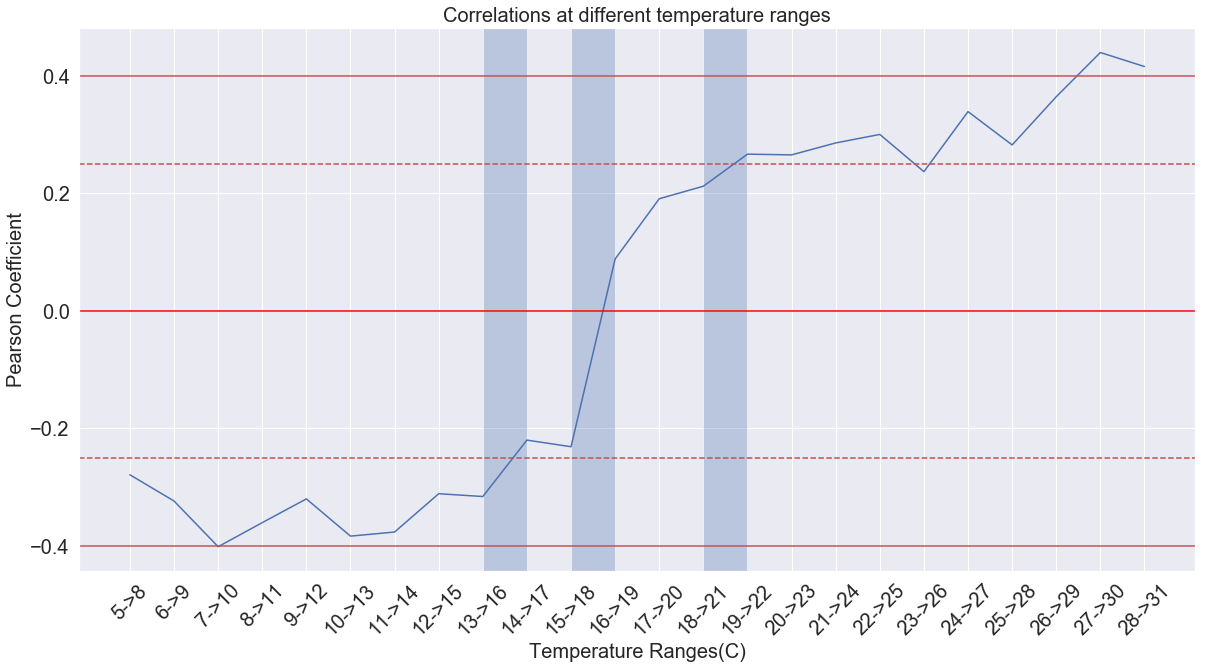

In [57]:
plt.figure(figsize=[20,10])
plt.plot(pd.Series(correlations))

plt.axhline(0, color='red')
plt.axhline(-0.4,c='r')
plt.axhline(0.4,c='r')
plt.axhline(0.25,c='r',linestyle='--')
plt.axhline(-0.25,c='r',linestyle='--')

plt.axvspan(8,9,alpha=0.3)
plt.axvspan(10,11,alpha=0.3)
plt.axvspan(13,14,alpha=0.3)

plt.yticks([-0.4,-0.2,0,0.2,0.4],size=20)
plt.xticks(rotation=45, size=20)
plt.title("Correlations at different temperature ranges",size=20)
plt.ylabel("Pearson Coefficient", size=20)
plt.xlabel("Temperature Ranges(C)",size=20);

We can see that the correlation changes from positive to negative but is still not very strong with a maximum magnitude of 0.4 

- Correlation increases above -0.25 from the lows(-0.4) between 13-17C.
- Correlation crosses 0 occurs between 15-19C which means the bottom of demand occurs at this temperature.
- Correlation increase above 0.25 at between 18->22C.

But looks like correlation is flat at temperatures below 15C at -0.4 and at temperatures above 26C

In [94]:
demand_by_hour=demand_actual.groupby(demand_actual.index.hour).mean()
temperature_by_hour=weather.temp_c.groupby(weather.temp_c.index.hour).mean()

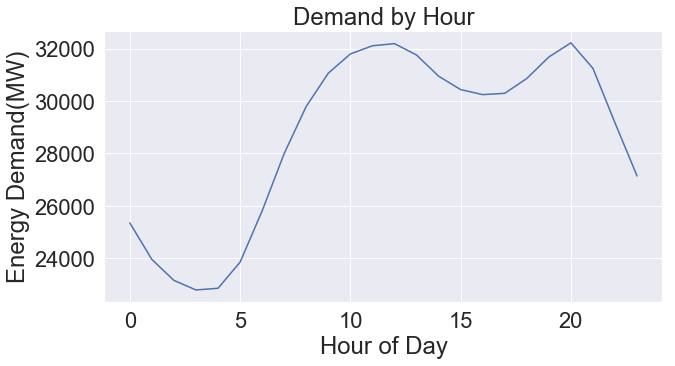

In [97]:
plt.figure(figsize=[10,5])
plt.plot(demand_by_hour.index,demand_by_hour)
plt.ylabel("Energy Demand(MW)")
plt.xlabel("Hour of Day")
plt.title("Demand by Hour");

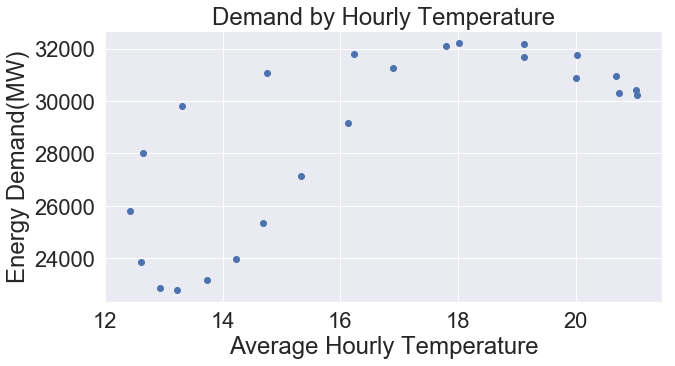

In [102]:
plt.figure(figsize=[10,5])
plt.scatter(temperature_by_hour,demand_by_hour)
plt.ylabel("Energy Demand(MW)")
plt.xlabel("Average Hourly Temperature")
plt.title("Demand by Hourly Temperature");

There are only 24 data points to judge a correlation from which would provide an inaccurate calculation but visually we can see that tempertaure increases throughout the day, there exists an early linear relationship but that dies out after temperature reaches 18C.

Intraday demand is more dependant on human behaviour/time of day rather than temperature.

# 2. Examining the means and standard deviations of the different seasons?

## 2.1. Is the mean of hourly demand during one season within a 95% confidence interval of another season?

Given that the high seasons of demand are summer and winter, can we say that they have the same mean?
Let's do a hypothesis test....

Our null hypothesis is:
#### "Demand & Summer will have the same mean"

This can be done by:
- 1- Combining the winter and summer demand series into one.
- 2- Finding the combined mean
- 3- Shifting the mean of the winter and summer dataset to have the same value as the combined mean
- 4- Bootstrap replicates of the mean for each season by bootstrapping samples 10,000 times.
- 5- Find the difference of the boostrapped mean replicates.
- 6- Find the observed difference of the actual means.
- 7- Test the observed differences against the observed difference by counting the number of boostrapped replicates that are equal to or greater than the observed difference.
- 8- Divide the count by the length of the array to obtain the p-value.
- 9- For a 95% confidence interval, if th p-value is less than 0.05, we shall reject the null hypothesis

In [195]:
#finding means
winter_mean=np.mean(winter_dem)
summer_mean=np.mean(summer_dem)

#combining dataset and mean
combined_ds = np.concatenate((winter_dem,summer_dem))
combined_mean=np.mean(combined_ds)

#computing difference of observed means
mean_diff = winter_mean - summer_mean

In [196]:
#shifting means to obtain the same mean 
shift_mean_winter = winter_dem -np.mean(winter_dem) + combined_mean
shift_mean_summer = summer_dem -np.mean(summer_dem) + combined_mean

(29125.017610974795, 29125.01761097417)

In [214]:
#bootstrapping means
bsm_reps_winter = np.empty(10000)
bsm_reps_summer = np.empty(10000)
for i in range(0,10000):
    bsm_reps_winter[i] = np.mean(np.random.choice(shift_mean_winter, len(shift_mean_winter)))

for i in range(0,10000):
    bsm_reps_summer[i] = np.mean(np.random.choice(shift_mean_summer, len(shift_mean_summer)))

In [215]:
#computing difference of bootstrapped means
bsm_diff_of_means = bsm_reps_winter - bsm_reps_summer
bsm_diff_of_means

array([  17.48283512,   28.33873212,  228.3394293 , ..., -128.3054094 ,
         20.34872142, -122.1278853 ])

In [210]:
#computing p-value
p = np.sum(bsm_diff_of_means >= mean_diff)/len(bsm_diff_of_means)
p*100

0.0

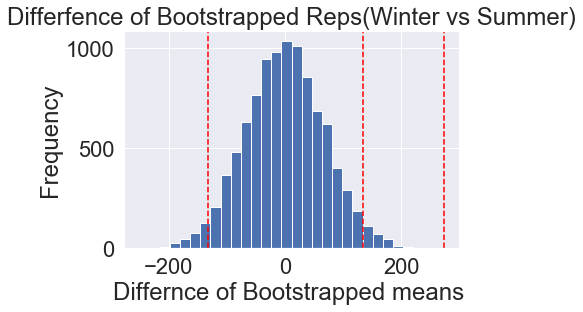

In [232]:
#plotting histogram of difference of boostrapped repplicates of mean
plt.hist(bsm_diff_of_means, bins=30)
plt.axvline(x=np.percentile(bsm_diff_of_means,(1-p)*100),color='red',linestyle='--')
plt.axvline(x=np.percentile(bsm_diff_of_means,2.5),color='red',linestyle='--')
plt.axvline(x=np.percentile(bsm_diff_of_means,97.5),color='red',linestyle='--')
plt.xlabel("Differnce of Bootstrapped means ")
plt.title("Differfence of Bootstrapped Reps(Winter vs Summer)")
plt.ylabel("Frequency");

It appears that we cannot say the winter and summer have the same demand. Therefore we reject the null hypothesis of summer and winter having the same mean. Let's use thew scipy function ttest_ind to confirm this. Which examines how close the means are to each other.  A low p means they are significantly differnet

In [231]:
ttest_ind(winter_dem,summer_dem, equal_var=False)

Ttest_indResult(statistic=5.007114105897687, pvalue=5.579462054762003e-07)

We can see a very low p-value, hence it is in line with our boostrap analysis.

What about the low seasons of Spring and Fall?

In [220]:
#finding means
fall_mean=np.mean(fall_dem)
spring_mean=np.mean(spring_dem)

#combining dataset and mean
combined_ds = np.concatenate((fall_dem,spring_dem))
combined_mean=np.mean(combined_ds)

#computing difference of observed means
mean_diff = fall_mean - spring_mean

#shifting means to obtain the same mean 
shift_mean_fall = fall_dem -np.mean(fall_dem) + combined_mean
shift_mean_spring= spring_dem -np.mean(spring_dem) + combined_mean

#bootstrapping means
bsm_reps_fall = np.empty(10000)
bsm_reps_spring = np.empty(10000)
for i in range(0,10000):
    bsm_reps_fall[i] = np.mean(np.random.choice(shift_mean_fall, len(shift_mean_fall)))

for i in range(0,10000):
    bsm_reps_spring[i] = np.mean(np.random.choice(shift_mean_spring, len(shift_mean_spring)))
    
#computing difference of bootstrapped means
bsm_diff_of_means = bsm_reps_fall - bsm_reps_spring

#computing p-value
p = np.sum(bsm_diff_of_means >= mean_diff)/len(bsm_diff_of_means)
p*100

0.0

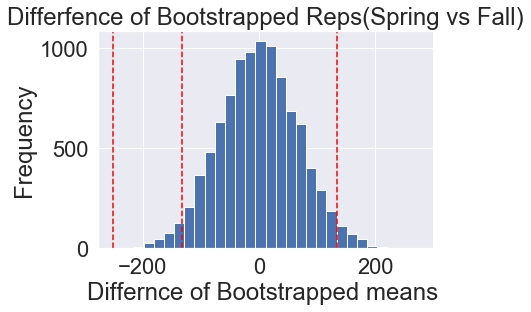

In [222]:
#plotting histogram of difference of boostrapped repplicates of mean
plt.hist(bsm_diff_of_means, bins=30)
plt.axvline(x=np.percentile(bsm_diff_of_means,p*100),color='red',linestyle='--')
plt.axvline(x=np.percentile(bsm_diff_of_means,2.5),color='red',linestyle='--')
plt.axvline(x=np.percentile(bsm_diff_of_means,97.5),color='red',linestyle='--')
plt.xlabel("Differnce of Bootstrapped means ")
plt.title("Differfence of Bootstrapped Reps(Spring vs Fall)")
plt.ylabel("Frequency");

It appears that we cannot say the spring and fall have the same demand. Therefore we reject the null hypothesis of Spring and fall having the same mean. Let's use thew scipy function ttest_ind to confirm this. Which examines how close the means are to each other.  A low p means they are significantly differnet

In [230]:
ttest_ind(fall_dem,spring_dem, equal_var=False)

Ttest_indResult(statistic=5.7986800069677376, pvalue=6.79902856366207e-09)

We can see a very low p-value, hence it is in line with our boostrap analysis.

## 2.2. Is the standard deviation of hourly demand during one season within a 95% confidence interval of another season?

Let's start with winter and Spring.
We can perform a hypothesis test that will require some bootstrapping and shifting of standard deviations.
Our null hypothesis is"
#### "Winter and Spring have the same standard deviation"

In [159]:
#finding std
winter_std=np.std(winter_dem)
spring_std=np.std(spring_dem)
std_diff = winter_std - spring_std

In [160]:
combined_ds = np.concatenate((winter_dem,spring_dem))
combined_std = np.std(combined_ds)
combined_std

4604.225775450207

We are assuming the null hypothesis to be True so we will shift both standard deviations to have the same value.

In [162]:
shifted_winter = (combined_std/winter_std)*(winter_dem-np.mean(winter_dem))+np.mean(winter_dem)
shifted_spring = (combined_std/spring_std)*(spring_dem-np.mean(spring_dem))+np.mean(spring_dem)
np.std(shifted_winter), np.std(shifted_spring)

(4604.225775450216, 4604.225775450213)

Now that we created 2 new samples with same standrad deviations, we will bootstrap replicates for the standard deviations

In [150]:
bs_reps_winter = np.empty(10000)
bs_reps_spring = np.empty(10000)
for i in range(0,10000):
    bs_reps_winter[i] = np.std(np.random.choice(shifted_winter, len(shifted_winter)))

for i in range(0,10000):
    bs_reps_spring[i] = np.std(np.random.choice(shifted_spring, len(shifted_spring)))

We will then create an array for the differences between the bootstrapped replicates.

In [151]:
bs_reps_diff = bs_reps_winter - bs_reps_spring
bs_reps_diff

array([ -7.71782662, -14.76015478,  22.23465032, ...,  -9.5812121 ,
       -13.39414568,  25.386485  ])

We will then calculate the p-value which is the probability that the bootstrapped differences of the replicates will be as high as the originally observed standard deviation difference.

In [152]:
p = np.sum(bs_reps_diff >= std_diff)/len(bs_reps_diff)
p

0.0

p-value is very low meaning that we reject the null hypothesis that winter and spring have the same standard deviation in demand. We shall plot a histogram of the diffrence of replicates, wioth dotted red lines as the 95% Confidence Interval and a dotted green line for our p-value.

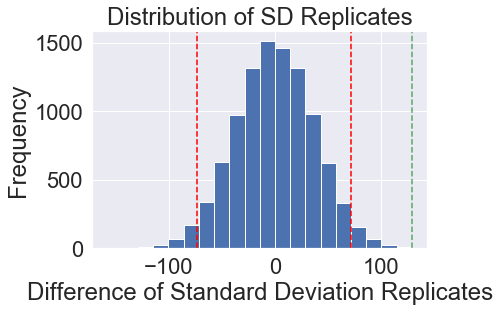

In [153]:
plt.hist(bs_reps_diff, bins=20)
plt.axvline(x=np.percentile(bs_reps_diff,2.5), color='red', linestyle='--')
plt.axvline(x=np.percentile(bs_reps_diff,97.5), color='red', linestyle='--')
plt.axvline(x=np.percentile(bs_reps_diff,(1-p)*100), color='g', linestyle='--')
plt.xlabel("Difference of Standard Deviation Replicates")
plt.ylabel("Frequency")
plt.title("Distribution of SD Replicates");

Let's see:
- Winter vs Summer
- Summer vs Fall

# What about Winter and Summer?

In [177]:
#finding std
winter_std=np.std(winter_dem)
summer_std=np.std(summer_dem)
std_diff_1 = winter_std - summer_std

combined_ds_1 = np.concatenate((winter_dem,summer_dem))
combined_std_1 = np.std(combined_ds_1)

shifted_winter = (combined_std_1/winter_std)*(winter_dem-np.mean(winter_dem))+np.mean(winter_dem)
shifted_summer = (combined_std_1/summer_std)*(summer_dem-np.mean(summer_dem))+np.mean(summer_dem)

In [178]:
bs_reps_winter = np.empty(10000)
bs_reps_summer = np.empty(10000)
for i in range(0,10000):
    bs_reps_winter[i] = np.std(np.random.choice(shifted_winter, len(shifted_winter)))

for i in range(0,10000):
    bs_reps_summer[i] = np.std(np.random.choice(shifted_summer, len(shifted_summer)))

In [179]:
bs_reps_diff_1 = bs_reps_winter - bs_reps_summer
p_1 = np.sum(bs_reps_diff_1 >= std_diff_1)/len(bs_reps_diff_1)
p_1

0.0

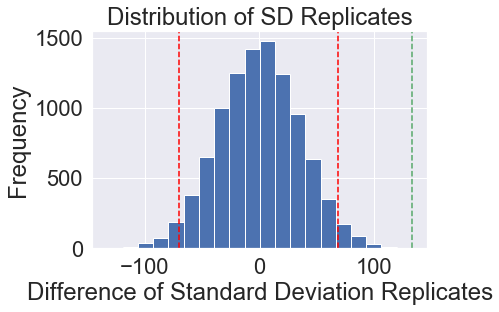

In [180]:
plt.hist(bs_reps_diff_1, bins=20)
plt.axvline(x=np.percentile(bs_reps_diff_1,2.5), color='red', linestyle='--')
plt.axvline(x=np.percentile(bs_reps_diff_1,97.5), color='red', linestyle='--')
plt.axvline(x=np.percentile(bs_reps_diff_1,(1-p)*100), color='g', linestyle='--')
plt.xlabel("Difference of Standard Deviation Replicates")
plt.ylabel("Frequency")
plt.title("Distribution of SD Replicates");

Winter and summer do not have the same deviation.

# What about Summer and Fall?

In [181]:
#finding std
fall_std=np.std(fall_dem)
summer_std=np.std(summer_dem)
std_diff_2 = fall_std - summer_std

combined_ds_2 = np.concatenate((fall_dem,summer_dem))
combined_std_2 = np.std(combined_ds_2)

shifted_fall = (combined_std_2/fall_std)*(fall_dem-np.mean(fall_dem))+np.mean(fall_dem)
shifted_summer = (combined_std_2/summer_std)*(summer_dem-np.mean(summer_dem))+np.mean(summer_dem)

In [182]:
bs_reps_fall = np.empty(10000)
bs_reps_summer = np.empty(10000)
for i in range(0,10000):
    bs_reps_fall[i] = np.std(np.random.choice(shifted_fall, len(shifted_fall)))

for i in range(0,10000):
    bs_reps_summer[i] = np.std(np.random.choice(shifted_summer, len(shifted_summer)))

In [183]:
bs_reps_diff_2 = bs_reps_fall - bs_reps_summer
p_2 = np.sum(bs_reps_diff_2 >= std_diff_2)/len(bs_reps_diff_2)
p_2

0.0

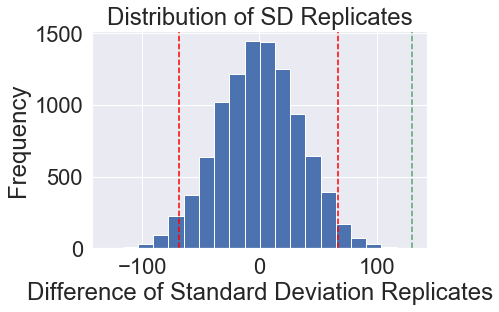

In [184]:
plt.hist(bs_reps_diff_2, bins=20)
plt.axvline(x=np.percentile(bs_reps_diff_2,2.5), color='red', linestyle='--')
plt.axvline(x=np.percentile(bs_reps_diff_2,97.5), color='red', linestyle='--')
plt.axvline(x=np.percentile(bs_reps_diff_2,(1-p)*100), color='g', linestyle='--')
plt.xlabel("Difference of Standard Deviation Replicates")
plt.ylabel("Frequency")
plt.title("Distribution of SD Replicates");

In [188]:
winter_std, spring_std, summer_std, fall_std

(4828.338971599379, 4284.085217338906, 4467.200746737825, 4605.478499976937)

Summer and Fall do not have the same standard deviation.

We can conclude the variation of demand in terms of meganitude is different for every season.

# 3.  Examining the correlations between weather features and demand

This can be summarized using seaborn's heat map and passing a correlation matrix as an argument. But first we have to merge demand and weather...

In [59]:
#merging demand and weather
demand_weather=pd.merge(left=weather, right=demand_actual, on='time') 

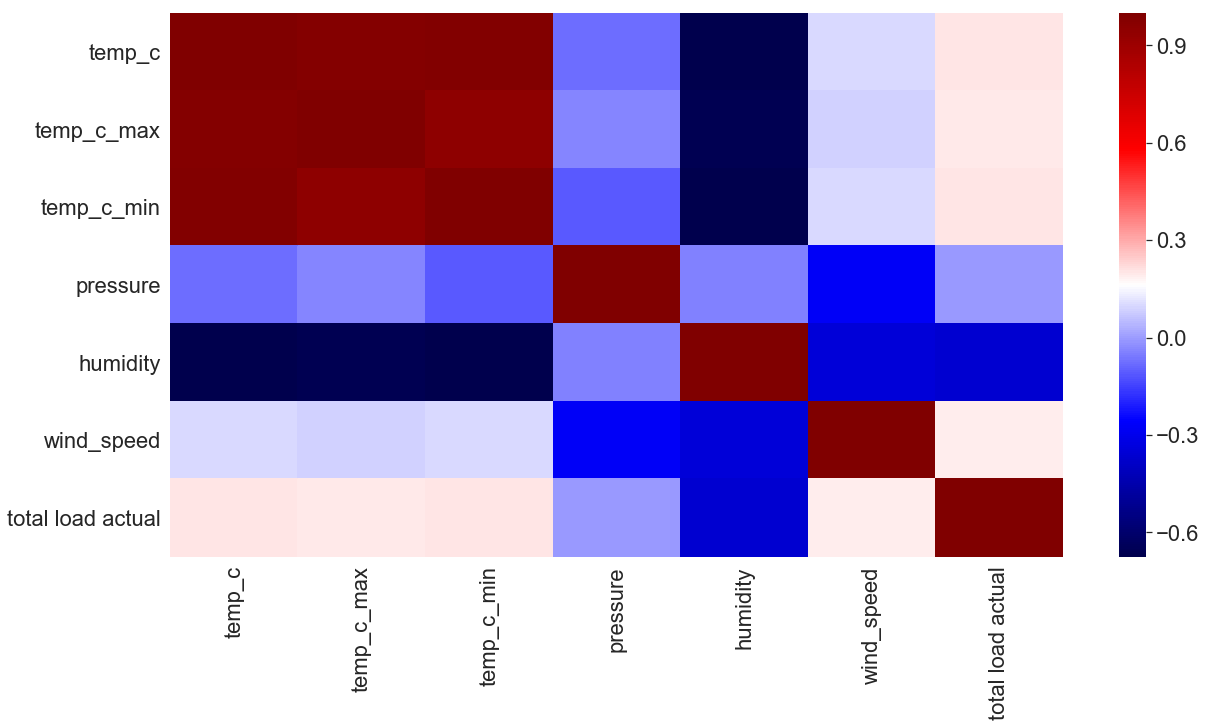

In [73]:
#plotting heat map of correlation coefficients between independent and dependant variables
plt.figure(figsize=[20,10])
sns.heatmap(demand_weather.corr(), cmap="seismic")
sns.set(font_scale=2)

The strongest correlation observed are between temperature and humidity, which is a negative correlation.
Demand and temperature are not linearly correlated but there exists a paraabolic relationship as seen in the previous section.
Demand looks slightly negatively correlated with humidity and completely uncorrelated with pressure.